In [1]:
import pyccl as ccl
import matplotlib.pyplot as plt

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96, 
                      transfer_function='eisenstein_hu_nowiggles')
cosmo2 = ccl.Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.95, 
                      transfer_function='boltzmann_camb')

In [3]:
kar = np.logspace(-4, 1, 100)
pk_lin = ccl.linear_matter_power(cosmo, kar, a=0.5)
pk_lin2 = ccl.linear_matter_power(cosmo, kar, a=0.5)
kpeak = kar[pk_lin.argmax()]

In [4]:
def model(ks, A,alpha, beta,gama=0.0, logstretch=False):
    if logstretch:
        ksp = np.exp(np.log(kpeak)+(np.log(ks)-np.log(kpeak))*(1+beta))*(1+alpha)
    else:   
        ksp = kpeak*(1+alpha)+(ks-kpeak)*(1+beta)*(1+alpha)
    
    return A*ccl.linear_matter_power(cosmo, ksp, a=0.5)*(ksp/kpeak*(1+alpha))**gama


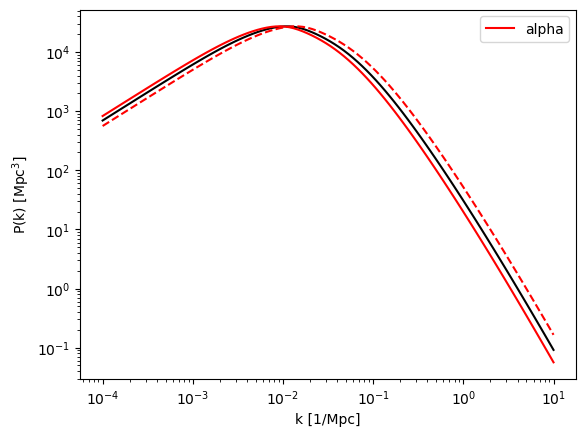

In [5]:
plt.plot(kar, pk_lin,'k-')
plt.plot(kar,model(kar,1,0.2,0,0),'r-',label='alpha')
plt.plot(kar,model(kar,1,-0.2,0,0),'r--')
plt.xlabel('k [1/Mpc]')
plt.ylabel('P(k) [Mpc$^3$]')
plt.loglog()
plt.legend()


/home/anze/Local/anaconda3/lib/python3.9/site-packages/pyccl/pk2d.py:273: RuntimeWarning: invalid value encountered in log
  f, status = eval_funcs[1](self.psp, np.log(k_use), a,


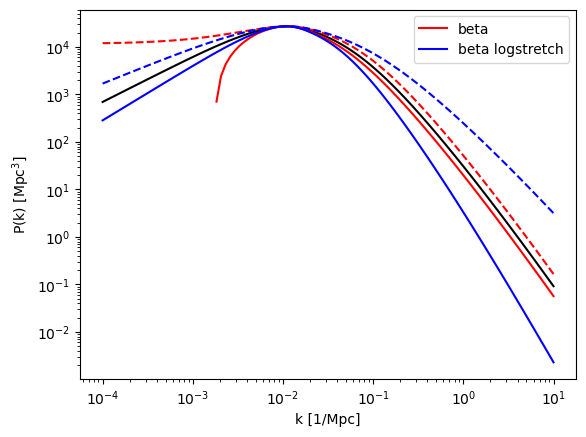

In [6]:
plt.plot(kar, pk_lin,'k-')
plt.plot(kar,model(kar,1,0,0.2,0),'r-',label='beta')
plt.plot(kar,model(kar,1,0,-0.2,0),'r--')
plt.plot(kar,model(kar,1,0,0.2,0,logstretch=True),'b-',label='beta logstretch')
plt.plot(kar,model(kar,1,0,-0.2,0,logstretch=True),'b--')
plt.xlabel('k [1/Mpc]')
plt.ylabel('P(k) [Mpc$^3$]')
plt.loglog()
plt.legend()

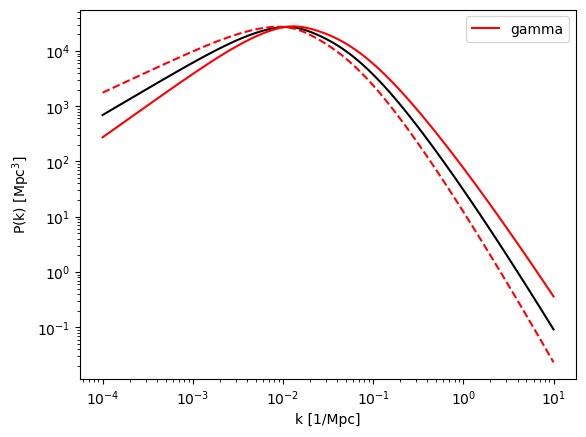

In [7]:
plt.plot(kar, pk_lin,'k-')
plt.plot(kar,model(kar,1,0,0,0.2),'r-',label='gamma')
plt.plot(kar,model(kar,1,0,0,-0.2),'r--')
plt.xlabel('k [1/Mpc]')
plt.ylabel('P(k) [Mpc$^3$]')
plt.loglog()
plt.legend()

In [8]:


def Fisher (kmin=0.1, kmax=0.5, Nk=50, err=0.1):
    A, alpha, beta,gamma  = 1.0, 0.0, 0.0,0.0 
    dA, dalpha, dbeta, dgamma = 0.01, 0.01, 0.01, 0.01
    ks = np.linspace(kmin,kmax,Nk)
    Pk = model(ks, A, alpha, beta)
    errs = Pk*err
    der_A = (model(ks, A+dA,alpha,beta)-model(ks, A-dA,alpha,beta))/(2*dA)
    der_alpha = (model(ks, A,alpha+dalpha,beta)-model(ks, A,alpha-dalpha,beta))/(2*dalpha)
    der_beta = (model(ks, A,alpha,beta+dbeta)-model(ks, A,alpha,beta-dbeta))/(2*dbeta)
    der_gamma = (model(ks, A,alpha,beta,gamma+dgamma)-model(ks, A,alpha,beta,gamma-dgamma))/(2*dgamma)
    ders = [der_A, der_alpha, der_beta, der_gamma]
    F = np.zeros((4,4))
    for i,d1 in enumerate(ders):
        for j,d2 in enumerate(ders):
            F[i,j] = np.sum(d1*d2/errs**2)
    
    #F=F[:3,:3] # remove gamma

    C = np.linalg.inv(F)
    return C

[]

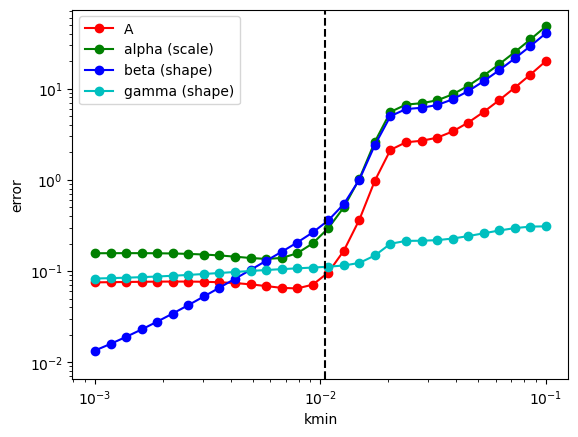

In [9]:
ksp = np.logspace(-3,-1,30)

def kmax_func(kmin):
    return 0.5#kmin*10

errA = np.array([np.sqrt( Fisher(kmin=kmin,kmax=kmax_func(kmin))[0,0]) for kmin in ksp])
erralpha = np.array([np.sqrt( Fisher(kmin=kmin,kmax=kmax_func(kmin))[1,1]) for kmin in ksp])
errbeta= np.array([np.sqrt( Fisher(kmin=kmin,kmax=kmax_func(kmin))[2,2]) for kmin in ksp])
errgamma= np.array([np.sqrt( Fisher(kmin=kmin,kmax=kmax_func(kmin))[3,3]) for kmin in ksp])

plt.plot(ksp,errA, 'ro-', label='A')
plt.plot(ksp,erralpha, 'go-',label='alpha (scale)')
plt.plot(ksp,errbeta, 'bo-',label='beta (shape)')
plt.plot(ksp,errgamma, 'co-',label='gamma (shape)')


plt.axline((kpeak,0), (kpeak,0.01), color='k', linestyle='--')
plt.legend()
plt.ylabel('error')
plt.xlabel('kmin')
#plt.semilogx()
plt.loglog()


In [10]:
kmin=0.008
C= Fisher(kmin=kmin,kmax=kmax_func(kmin))
C, C/np.outer(np.sqrt(np.diag(C)),np.sqrt(np.diag(C)))

(array([[ 0.00418568,  0.00583555,  0.00070071,  0.00280192],
        [ 0.00583555,  0.02542659, -0.01649078,  0.00430613],
        [ 0.00070071, -0.01649078,  0.04421037,  0.01601493],
        [ 0.00280192,  0.00430613,  0.01601493,  0.01152551]]),
 array([[ 1.        ,  0.56565851,  0.05151024,  0.40340612],
        [ 0.56565851,  1.        , -0.49185262,  0.25154319],
        [ 0.05151024, -0.49185262,  1.        ,  0.70946816],
        [ 0.40340612,  0.25154319,  0.70946816,  1.        ]]))

In [11]:
kmin=0.1
C= Fisher(kmin=kmin,kmax=kmax_func(kmin))
C, C/np.outer(np.sqrt(np.diag(C)),np.sqrt(np.diag(C)))

(array([[ 4.01471772e+02,  9.64342511e+02, -8.09404470e+02,
         -4.15104865e+00],
        [ 9.64342511e+02,  2.31693638e+03, -1.94505085e+03,
         -1.01251219e+01],
        [-8.09404470e+02, -1.94505085e+03,  1.63312595e+03,
          8.61660135e+00],
        [-4.15104865e+00, -1.01251219e+01,  8.61660135e+00,
          9.55839778e-02]]),
 array([[ 1.        ,  0.9998774 , -0.99960461, -0.67009714],
        [ 0.9998774 ,  1.        , -0.99991726, -0.68037862],
        [-0.99960461, -0.99991726,  1.        ,  0.68965773],
        [-0.67009714, -0.68037862,  0.68965773,  1.        ]]))

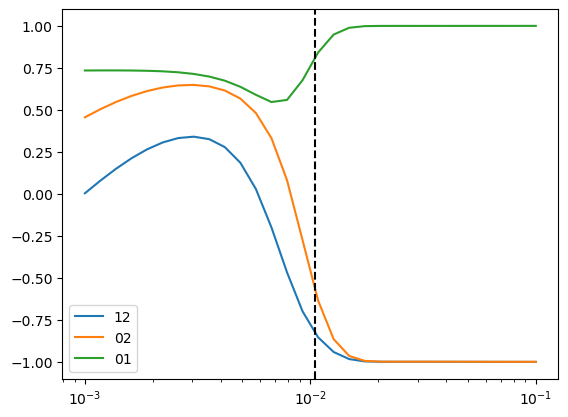

In [12]:
def gcorr(i,j,F):
    return F[i,j]/np.sqrt(F[i,i]*F[j,j])
err12= np.array([gcorr(1,2,Fisher(kmin=kmin,kmax=kmax_func(kmin))) for kmin in ksp])
err02= np.array([gcorr(0,2,Fisher(kmin=kmin,kmax=kmax_func(kmin))) for kmin in ksp])
err01= np.array([gcorr(0,1,Fisher(kmin=kmin,kmax=kmax_func(kmin))) for kmin in ksp])
plt.plot(ksp,err12,label='12')
plt.plot(ksp,err02,label='02')
plt.plot(ksp,err01,label='01')
plt.semilogx()
plt.axline((kpeak,0), (kpeak,0.01), color='k', linestyle='--')
plt.legend()